# MALA

The Metropolis-Adjusted Langevin Algorithm (MALA) is essentially a Metropolis-Hastings algorithm but with a better proposal distribution $q$. Intuitively, we can think of the proposal as 'better' because it incorporates information about the _gradient_ of the distribution we are attempting to simulate when choosing a new point, rather than just being a random guess at where might be nice to go next.

The Langevin diffusion which produces an invariant distribution $\pi$ is given by:

$$
d \mathbf{\Lambda}_t = \sigma d\mathbf{B}_t + \frac{\sigma^2}{2} \nabla \log(\pi(\mathbf{\Lambda_t})) dt
$$

Here $\mathbf{B}_t$ is an $n$-dimensional Brownian motion, $\pi$ is the $n$-dimensional distribution we wish to sample from and $\sigma$ is, as in Metropolis-Hastings, a tuning parameter affecting the step size.

We need a discretization of the above equation to actually be able to produce samples, and this is where the Hastings reject step enters play. The discretization used is based on an Euler scheme and is given by:

$$
\tilde{\mathbf{\Lambda}}_{t+1} = \tilde{\mathbf{\Lambda}}_t + \sigma_n \mathbf{Z}_{t+1} + 
    \frac{\sigma^2}{2} \nabla \log(\pi(\tilde{\mathbf{\Lambda_t}}))
$$

The problem here is that _any_ discretization of the SDE above breaks the property that the invariant distribution will be $\pi$. This necessitates a reject step.

In [14]:
%matplotlib inline
from autograd import numpy as np
import autograd
import matplotlib.pyplot as plt
import mcmc
%load_ext mcmc
%mcmc notebook

In [15]:
def mh_mcmc(x_0, log_pi, proposal, n, with_stats=False):
    x_0 = np.asarray(x_0)
    x = x_0
    chain = np.empty((n, x_0.shape[0]))
    chain[0, :] = x_0
    acceptances = 0
    
    proposals=0
    while True:
        proposals+=1
        y = proposal(x)
        r = log_pi(y) - log_pi(x) # metropolis-hastings update
        #r = h(y) / h(x) # metropolis update
        #print y, r, h(y), h(x)
        a = min(1, np.exp(r))
        if np.random.uniform() < a:
            chain[acceptances] = y
            x = y
            acceptances+=1
            if acceptances == n: break
    if not with_stats:
        return chain
    
    return chain, {'proposals': proposals}

In [16]:
# mean and variance for the distribution we will be sampling
mu = np.array([[0.], [1.]])
Sigma = np.array([[2., 3.], [2., 1.]])
Sigma = Sigma.T.dot(Sigma)
Sigma_inv = np.linalg.inv(Sigma)

In [17]:
def log_pi(x):
    if len(x.shape) == 1:
        x = x[:,None]
    return -np.dot(np.dot((x-mu).T, Sigma_inv), x-mu)

grad_fun = autograd.grad(log_pi)

In [18]:
def mala_proposal(x, sigma):
    return x + sigma * np.random.normal(size=x.shape) + sigma**2 / 2. * grad_fun(x)
def proposal_proba(x, y, sigma):
    sigma2 = sigma**2
    exponent = -np.sum((x - y - sigma2 / 2 * grad_fun(x))**2) / (2. * sigma2)
    return np.exp(exponent) / (2 * np.pi * sigma2)**(x.shape[0] / 2.)
sigma = 0.2
proposal = lambda x: mala_proposal(x, sigma)

In [19]:
x_0 = np.array([2., 2.])
samp_1 = mh_mcmc(x_0, log_pi, proposal, 10000)

In [23]:
from mcmc.rwm import mala_proposal as mp
propose = mp(grad_fun, sigma)
#propose = lambda x: mala_proposal(x, sigma)
samp_2 = mcmc.rwm(10000, propose, log_pi, lambda x: 0, x_0)

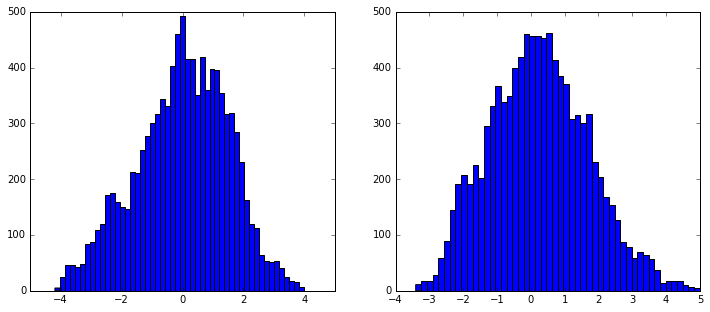

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(samp_2[:,0], 50);
plt.subplot(122)
plt.hist(samp_1[:,0], 50);

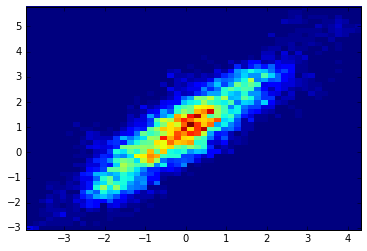

In [25]:
plt.hist2d(samp[:,0], samp[:,1], 50);

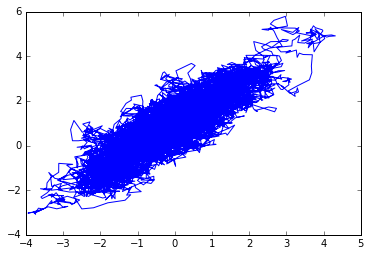

In [26]:
plt.plot(samp[:,0], samp[:,1])